In [533]:
import pandas as pd
import numpy as np
import os

print(os.getcwd())
# Load the file
df = pd.read_csv('../Gen_data/gen_hourly_MW_all.csv')
ptype = "Wind Onshore"
df = df[(df["Production Type"] == ptype)].copy()
df = df.rename(columns={
    "Generation (MW)": "Generation (MWh)"
})
# Check the first few rows
print(df.dtypes)
df.head()

E:\202510\2025-26-Data-driven\Advance_forecast
datetime             object
Area                 object
Production Type      object
Generation (MWh)    float64
dtype: object


,datetime,Area,Production Type,Generation (MWh)
158144,2022-01-01 00:00:00,BZN|ES,Wind Onshore,6342.0
158145,2022-01-01 01:00:00,BZN|ES,Wind Onshore,6398.0
158146,2022-01-01 02:00:00,BZN|ES,Wind Onshore,6456.0
158147,2022-01-01 03:00:00,BZN|ES,Wind Onshore,6144.0
158148,2022-01-01 04:00:00,BZN|ES,Wind Onshore,5943.0


In [534]:
# Convert datetime column to proper datetime format
df['ds'] = pd.to_datetime(df['datetime'])

# Rename the generation column for RandomForestModel (use the MWh column name)
df['y'] = df['Generation (MWh)']

# Keep only the necessary columns
df = df[['ds', 'y']].sort_values('ds')

print(df.dtypes)
print(df.head())
print(f"\nData range: {df['ds'].min()} to {df['ds'].max()}")
print(f"Total records: {len(df)}")

ds    datetime64[ns]
y            float64
dtype: object
                        ds       y
158144 2022-01-01 00:00:00  6342.0
158145 2022-01-01 01:00:00  6398.0
158146 2022-01-01 02:00:00  6456.0
158147 2022-01-01 03:00:00  6144.0
158148 2022-01-01 04:00:00  5943.0

Data range: 2022-01-01 00:00:00 to 2024-12-31 23:00:00
Total records: 26301


## Filter data 2022-24 3-9

In [535]:
# create new relevant variables or filters when useful
df['ds'] = pd.to_datetime(df['ds'], format='%Y/%m/%d %H:%M:%S')
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day
df['weekday'] = df['ds'].dt.day_name()  # weekdays
df['is_weekend'] = df['ds'].dt.dayofweek >= 5  # True = weekends
df['season'] = df['ds'].dt.quarter  # season 1-4
# def seasons function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

# apply season
df['season'] = df['month'].apply(get_season)

df = df[(df['month'] >= 1) & (df['month'] <= 12)].copy()

print(f"Filtered data for March to September:")
print(f"  Period: {df['ds'].min()} to {df['ds'].max()}")
print(f"  Total records: {len(df)}")
print(f"  Years covered: {sorted(df['year'].unique())}")

df[df['season'] == 'Summer'].head()

Filtered data for March to September:
  Period: 2022-01-01 00:00:00 to 2024-12-31 23:00:00
  Total records: 26301
  Years covered: [2022, 2023, 2024]


,ds,y,year,month,day,weekday,is_weekend,season
161767,2022-06-01 00:00:00,3090.0,2022,6,1,Wednesday,False,Summer
161768,2022-06-01 01:00:00,3297.0,2022,6,1,Wednesday,False,Summer
161769,2022-06-01 02:00:00,3487.0,2022,6,1,Wednesday,False,Summer
161770,2022-06-01 03:00:00,3693.0,2022,6,1,Wednesday,False,Summer
161771,2022-06-01 04:00:00,3694.0,2022,6,1,Wednesday,False,Summer


In [536]:
# Data quality check and outlier detection
print("Data Quality Analysis:")
print("=" * 60)

# Check for missing values
missing_count = df['y'].isna().sum()
print(f"Missing values: {missing_count}")

# Check for negative values (shouldn't exist for solar generation)
negative_count = (df['y'] < 0).sum()
print(f"Negative values: {negative_count}")

# Detect outliers using IQR method
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # 3*IQR for extreme outliers
upper_bound = Q3 + 3 * IQR

outliers = ((df['y'] < lower_bound) | (df['y'] > upper_bound)).sum()
print(f"Outliers detected (3*IQR method): {outliers}")

# Show basic statistics
print(f"\nGeneration statistics:")
print(f"  Min: {df['y'].min():.2f} MWh")
print(f"  Max: {df['y'].max():.2f} MWh")
print(f"  Mean: {df['y'].mean():.2f} MWh")
print(f"  Median: {df['y'].median():.2f} MWh")
print(f"  Std: {df['y'].std():.2f} MWh")
print(f"  95th percentile: {df['y'].quantile(0.95):.2f} MWh")
print(f"  99th percentile: {df['y'].quantile(0.99):.2f} MWh")

# Cap extreme outliers to reasonable maximum
df_cleaned = df.copy()
max_reasonable = df['y'].quantile(0.99) * 1.1  # 110% of 99th percentile
df_cleaned.loc[df_cleaned['y'] > max_reasonable, 'y'] = max_reasonable
df_cleaned.loc[df_cleaned['y'] < 0, 'y'] = 0  # Remove any negative values

capped_count = (df['y'] != df_cleaned['y']).sum()
print(f"\nCapped {capped_count} extreme values to max: {max_reasonable:.2f} MWh")
print("Data is ready for modeling")

# Update df with cleaned data
df = df_cleaned

Data Quality Analysis:
Missing values: 0
Negative values: 0
Outliers detected (3*IQR method): 0

Generation statistics:
  Min: 190.00 MWh
  Max: 20718.00 MWh
  Mean: 6800.48 MWh
  Median: 6102.00 MWh
  Std: 3949.71 MWh
  95th percentile: 14380.00 MWh
  99th percentile: 17227.00 MWh

Capped 35 extreme values to max: 18949.70 MWh
Data is ready for modeling


In [537]:
wind_df = pd.read_csv("../Gen_data/Wind_2022_2024.csv")

## add_wind_regressor


In [538]:
# Split data into train (70%), validation (20%), and test (10%)
# Using only March to September data from 2022-2024
total_rows = len(df)
train_size = int(0.66 * total_rows)
val_size = int(0.33 * total_rows)

train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

def add_wind_regressor(df, wind_df):
    df['ds'] = pd.to_datetime(df['ds'])
    wind_df['hourly__time'] = pd.to_datetime(wind_df['hourly__time'])

    merged = pd.merge_asof(
        df.sort_values('ds'),
        wind_df.sort_values('hourly__time'),
        left_on='ds',
        right_on='hourly__time',
        direction='nearest',
        tolerance=pd.Timedelta('30min')
    )

    # Time
    merged['hour'] = merged['ds'].dt.hour
    merged['month'] = merged['ds'].dt.month

    # wind_direction
    wind_dir_rad = np.deg2rad(merged['hourly__wind_direction_100m'])
    merged['wind_direction_sin'] = np.sin(wind_dir_rad)
    merged['wind_direction_cos'] = np.cos(wind_dir_rad)

    '''
    # On average across Spain:
    # Wind energy is stronger in spring (March to May) and winter (November to February)
    # Weaker in summer (June to August).
    merged['season_factor'] = (
        0.5 * (np.cos((merged['month'] - 2) / 12 * 2 * np.pi) ** 2) +
        0.5 * (np.cos((merged['month'] - 12) / 12 * 2 * np.pi) ** 2)
    )
    # unified to [0,1]
    merged['season_factor'] = (merged['season_factor'] - merged['season_factor'].min()) / \
                              (merged['season_factor'].max() - merged['season_factor'].min())
    '''
    # 使用更符合西班牙风能分布的季节因子
    def calculate_season_factor(month):
        # 根据西班牙地理条件调整
        if month in [12, 1, 2]:  # 冬春季节风能较强
            return 1
        elif month in [3, 4, 5]:  # 夏季风能较弱
            return 0.8
        else:
            return 0.6

    merged['season_factor'] = merged['month'].apply(calculate_season_factor)


    merged['wind_potential_index'] = (
        merged['hourly__wind_speed_100m'] * merged['season_factor']
    )

    return merged

train_df = add_wind_regressor(train_df, wind_df)
val_df = add_wind_regressor(val_df, wind_df)
test_df = add_wind_regressor(test_df, wind_df)

print(f"Dataset: March to September (2022-2024)")
print(f"Total data points: {total_rows}")
print(f"\nTraining set: {len(train_df)} records ({len(train_df)/total_rows*100:.1f}%)")
print(f"  Period: {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"\nValidation set: {len(val_df)} records ({len(val_df)/total_rows*100:.1f}%)")
print(f"  Period: {val_df['ds'].min()} to {val_df['ds'].max()}")
print(f"\nTest set: {len(test_df)} records ({len(test_df)/total_rows*100:.1f}%)")
print(f"  Period: {test_df['ds'].min()} to {test_df['ds'].max()}")

# Show wind data by hour
print(f"\nWind Pattern (sample):")
hourly_elevation = train_df.groupby('hour')['wind_potential_index'].mean().reset_index()
for _, row in hourly_elevation.iterrows():
    print(f"  Hour {int(row['hour']):02d}:00 - wind_potential_index: {row['wind_potential_index']:.3f}")

Dataset: March to September (2022-2024)
Total data points: 26301

Training set: 17358 records (66.0%)
  Period: 2022-01-01 00:00:00 to 2023-12-25 07:00:00

Validation set: 8679 records (33.0%)
  Period: 2023-12-25 08:00:00 to 2024-12-20 23:00:00

Test set: 264 records (1.0%)
  Period: 2024-12-21 00:00:00 to 2024-12-31 23:00:00

Wind Pattern (sample):
  Hour 00:00 - wind_potential_index: 9.563
  Hour 01:00 - wind_potential_index: 10.153
  Hour 02:00 - wind_potential_index: 10.165
  Hour 03:00 - wind_potential_index: 10.459
  Hour 04:00 - wind_potential_index: 10.664
  Hour 05:00 - wind_potential_index: 10.893
  Hour 06:00 - wind_potential_index: 11.237
  Hour 07:00 - wind_potential_index: 11.364
  Hour 08:00 - wind_potential_index: 11.116
  Hour 09:00 - wind_potential_index: 10.909
  Hour 10:00 - wind_potential_index: 11.180
  Hour 11:00 - wind_potential_index: 11.416
  Hour 12:00 - wind_potential_index: 11.754
  Hour 13:00 - wind_potential_index: 12.211
  Hour 14:00 - wind_potential_in

In [539]:
train_df.describe()

,ds,y,year,month,day,hourly__time,hourly__apparent_temperature,hourly__wind_speed_100m,hourly__wind_direction_100m,hour,wind_direction_sin,wind_direction_cos,season_factor,wind_potential_index
count,17358,17358.000000,17358.000000,17358.000000,17358.000000,17358,17358.000000,17358.000000,17358.000000,17358.000000,17358.000000,17358.000000,17358.000000,17358.000000
mean,2022-12-28 15:45:41.375734272,6865.971429,2022.495391,6.475976,15.604736,2022-12-28 15:45:41.375734272,16.920544,14.838645,206.630545,11.497408,-0.203258,0.016206,0.746722,11.256579
min,2022-01-01 00:00:00,229.000000,2022.000000,1.000000,1.000000,2022-01-01 00:00:00,-6.100000,0.000000,1.000000,0.000000,-1.000000,-1.000000,0.600000,0.000000
25%,2022-06-30 20:15:00,3661.250000,2022.000000,4.000000,8.000000,2022-06-30 20:15:00,9.700000,8.400000,122.000000,5.000000,-0.857167,-0.642788,0.600000,5.820000
50%,2022-12-28 15:30:00,6123.500000,2022.000000,6.000000,16.000000,2022-12-28 15:30:00,16.700000,13.400000,225.000000,11.000000,-0.469472,0.069756,0.600000,9.480000
75%,2023-06-27 11:45:00,9435.750000,2023.000000,9.000000,23.000000,2023-06-27 11:45:00,24.500000,19.500000,292.000000,17.000000,0.529919,0.642788,0.800000,14.720000
max,2023-12-25 07:00:00,18949.700000,2023.000000,12.000000,31.000000,2023-12-25 07:00:00,40.300000,60.500000,360.000000,23.000000,1.000000,1.000000,1.000000,55.900000
std,NaN,3983.949163,0.499993,3.423326,8.753014,NaN,9.194483,8.759549,98.822004,6.922743,0.714909,0.668867,0.164290,7.521590


In [559]:
from src.random_forest import RandomForestModel
import matplotlib.pyplot as plt

# ------------------------------
# 1. 创建模型
# ------------------------------
model = RandomForestModel(
)

# ------------------------------
# 2. 准备训练数据（确保包含所需列）
#   必需列: ds, y, wind_speed, wind_direction, daily_weather_code
#   可选列: wind_potential_index, floor
# ------------------------------
train_df['floor'] = 0   # 风电不可能小于 0，因此作为下限

print("Training RandomForestModel for wind power forecasting...")
print("=" * 60)
print("Model Configuration:")
print(f"  - n_estimators: {model.model.n_estimators}")
print(f"  - max_depth: {model.model.max_depth}")
print(f"  - Random state: {model.model.random_state}")
print("=" * 60)

# ------------------------------
# 3. 训练模型（新版 RF 模型的正确用法）
# ------------------------------
model.fit(train_df)

print("\nTraining complete!")
print("=" * 60)

Training RandomForestModel for wind power forecasting...
Model Configuration:
  - n_estimators: 300
  - max_depth: 20
  - Random state: 42

Training complete!


In [541]:
# Validate model on validation set
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

val_df_pred = val_df.copy()
val_df_pred['floor'] = 0
val_forecast = model.predict(val_df_pred)

# Clip predictions to non-negative values (safety check)
val_forecast['yhat'] = val_forecast['yhat'].clip(lower=0)

# Reset indices to align properly
val_actual = val_df['y'].values
val_pred = val_forecast['yhat'].values

# Calculate validation metrics
val_mae = mean_absolute_error(val_actual, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_actual, val_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold for meaningful generation)
# This filters out nighttime and very low generation periods
threshold = 1000  # MWh
significant_mask = val_actual >= threshold
if significant_mask.sum() > 0:
    val_mape = np.mean(np.abs((val_actual[significant_mask] - val_pred[significant_mask]) / val_actual[significant_mask])) * 100
else:
    val_mape = np.nan

print("Validation Set Performance:")
print("=" * 50)
print(f"MAE:  {val_mae:.2f} MWh")
print(f"RMSE: {val_rmse:.2f} MWh")
if not np.isnan(val_mape):
    print(f"MAPE (generation >= {threshold} MWh): {val_mape:.2f}%")
else:
    print(f"MAPE: N/A")

# Show additional info
zero_count = (val_actual == 0).sum()
low_gen_count = ((val_actual > 0) & (val_actual < threshold)).sum()
print(f"\nData distribution in validation set:")
print(f"  Zero values: {zero_count} ({zero_count/len(val_actual)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(val_actual)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(val_actual)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {val_pred.min():.2f} MWh")
print(f"  Max: {val_pred.max():.2f} MWh")
print(f"  Mean: {val_pred.mean():.2f} MWh")


Validation Set Performance:
MAE:  2680.07 MWh
RMSE: 3410.86 MWh
MAPE (generation >= 1000 MWh): 58.83%

Data distribution in validation set:
  Zero values: 0 (0.0%)
  Low generation (0-1000 MWh): 178 (2.1%)
  Significant generation (>=1000 MWh): 8501 (97.9%)

Prediction range:
  Min: 1323.87 MWh
  Max: 17720.73 MWh
  Mean: 6816.88 MWh


In [542]:
# Test model on test set
test_df_pred = test_df.copy()
test_df_pred['floor'] = 0
test_forecast = model.predict(test_df_pred)

# Clip predictions to non-negative values (safety check)
test_forecast['yhat'] = test_forecast['yhat'].clip(lower=0)

# Reset indices to align properly
test_actual = test_df['y'].values
test_pred = test_forecast['yhat'].values

# Calculate test metrics
test_mae = mean_absolute_error(test_actual, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold)
threshold = 1000  # MWh
significant_mask = test_actual >= threshold
if significant_mask.sum() > 0:
    test_mape = np.mean(np.abs((test_actual[significant_mask] - test_pred[significant_mask]) / test_actual[significant_mask])) * 100
else:
    test_mape = np.nan

print("Test Set Performance:")
print("=" * 50)
print(f"MAE:  {test_mae:.2f} MWh")
print(f"RMSE: {test_rmse:.2f} MWh")
if not np.isnan(test_mape):
    print(f"MAPE (generation >= {threshold} MWh): {test_mape:.2f}%")
else:
    print(f"MAPE: N/A")

# Show additional info
zero_count = (test_actual == 0).sum()
low_gen_count = ((test_actual > 0) & (test_actual < threshold)).sum()
print(f"\nData distribution in test set:")
print(f"  Zero values: {zero_count} ({zero_count/len(test_actual)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(test_actual)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(test_actual)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {test_pred.min():.2f} MWh")
print(f"  Max: {test_pred.max():.2f} MWh")
print(f"  Mean: {test_pred.mean():.2f} MWh")

Test Set Performance:
MAE:  3034.51 MWh
RMSE: 3643.49 MWh
MAPE (generation >= 1000 MWh): 92.30%

Data distribution in test set:
  Zero values: 0 (0.0%)
  Low generation (0-1000 MWh): 19 (7.2%)
  Significant generation (>=1000 MWh): 245 (92.8%)

Prediction range:
  Min: 2123.59 MWh
  Max: 14683.18 MWh
  Mean: 5998.55 MWh


In [543]:
# Load actual 2025 data for comparison
df_2025 = pd.read_csv("../Gen_data/Wind_Onshore_hourly_2025.csv")
df_2025['ds'] = pd.to_datetime(df_2025['datetime'])
df_2025['y'] = df_2025['Generation (MWh)']
df_2025

,datetime,Area,Production Type,Generation (MWh),ds,y
0,2025/1/1 0:00,BZN|ES,Wind Onshore,2949.0,2025-01-01 00:00:00,2949.0
1,2025/1/1 1:00,BZN|ES,Wind Onshore,3222.0,2025-01-01 01:00:00,3222.0
2,2025/1/1 2:00,BZN|ES,Wind Onshore,3428.0,2025-01-01 02:00:00,3428.0
3,2025/1/1 3:00,BZN|ES,Wind Onshore,3526.0,2025-01-01 03:00:00,3526.0
4,2025/1/1 4:00,BZN|ES,Wind Onshore,3609.0,2025-01-01 04:00:00,3609.0
...,...,...,...,...,...,...
8755,2025/12/31 19:00,BZN|ES,Wind Onshore,0.0,2025-12-31 19:00:00,0.0
8756,2025/12/31 20:00,BZN|ES,Wind Onshore,0.0,2025-12-31 20:00:00,0.0
8757,2025/12/31 21:00,BZN|ES,Wind Onshore,0.0,2025-12-31 21:00:00,0.0
8758,2025/12/31 22:00,BZN|ES,Wind Onshore,0.0,2025-12-31 22:00:00,0.0


## Predict 2025

In [544]:
df_2025['month'] = df_2025['ds'].dt.month
df_2025 = df_2025[(df_2025['month'] >= 3) & (df_2025['month'] <= 9)].copy()

wind_df1 = pd.read_csv("../Gen_data/Wind_2025_1.csv")
# Create future dataframe with regressor
future_2025 = df_2025[['ds']].copy()
future_2025['floor'] = 0
future_2025 = add_wind_regressor(future_2025,wind_df1)

future_2025.describe

<bound method NDFrame.describe of                       ds  floor        hourly__time  \
0    2025-03-01 00:00:00      0 2025-03-01 00:00:00   
1    2025-03-01 01:00:00      0 2025-03-01 01:00:00   
2    2025-03-01 02:00:00      0 2025-03-01 02:00:00   
3    2025-03-01 03:00:00      0 2025-03-01 03:00:00   
4    2025-03-01 04:00:00      0 2025-03-01 04:00:00   
...                  ...    ...                 ...   
5131 2025-09-30 19:00:00      0 2025-09-30 19:00:00   
5132 2025-09-30 20:00:00      0 2025-09-30 20:00:00   
5133 2025-09-30 21:00:00      0 2025-09-30 21:00:00   
5134 2025-09-30 22:00:00      0 2025-09-30 22:00:00   
5135 2025-09-30 23:00:00      0 2025-09-30 23:00:00   

      hourly__apparent_temperature  hourly__wind_speed_100m  \
0                              5.5                     23.0   
1                              6.2                     20.2   
2                              5.8                     20.1   
3                              5.6                   

In [545]:

# Make predictions
forecast_2025 = model.predict(future_2025)

# Clip predictions to non-negative values
forecast_2025['yhat'] = forecast_2025['yhat'].clip(lower=0)

# Calculate metrics for 2025 forecast
actual_2025 = df_2025['y'].values
pred_2025 = forecast_2025['yhat'].values

mae_2025 = mean_absolute_error(actual_2025, pred_2025)
rmse_2025 = np.sqrt(mean_squared_error(actual_2025, pred_2025))
mape_2025 = np.mean(np.abs((actual_2025 - pred_2025) / (actual_2025 + 1e-8))) * 100

print(f"2025 Forecast Performance (March-September): MAE={mae_2025:.2f} MWh, RMSE={rmse_2025:.2f} MWh, MAPE={mape_2025:.2f}%")

forecast_2025

2025 Forecast Performance (March-September): MAE=2683.55 MWh, RMSE=3295.94 MWh, MAPE=16046143582.90%


,ds,yhat
0,2025-03-01 00:00:00,10930.395301
1,2025-03-01 01:00:00,10378.230487
2,2025-03-01 02:00:00,10698.015001
3,2025-03-01 03:00:00,9568.723837
4,2025-03-01 04:00:00,8783.457887
...,...,...
5131,2025-09-30 19:00:00,9087.231267
5132,2025-09-30 20:00:00,9261.137479
5133,2025-09-30 21:00:00,8235.402094
5134,2025-09-30 22:00:00,8028.172222


In [546]:

# Analyze hourly patterns with wind potential for 2025 forecast
df_2025['hour'] = df_2025['ds'].dt.hour
forecast_2025_merged = forecast_2025[['ds', 'yhat']].copy()
forecast_2025_merged['hour'] = forecast_2025_merged['ds'].dt.hour

hourly_stats = df_2025.groupby('hour')['y'].agg(['mean', 'std', 'min', 'max'])
hourly_pred = forecast_2025_merged.groupby('hour')['yhat'].mean()
hourly_wind = future_2025.groupby(future_2025['ds'].dt.hour)['wind_potential_index'].mean()

print("\n" + "=" * 80)
print("Hourly Statistics (March-September 2025 Forecast):")
print("=" * 80)
print(f"{'Hour':<6} {'Actual':>10} {'Predicted':>10} {'Wind Potential':>12} {'Status':>15}")
print("-" * 80)

for hour in range(24):
    actual_mean = hourly_stats.loc[hour, 'mean'] if hour in hourly_stats.index else 0
    pred_mean = hourly_pred.loc[hour] if hour in hourly_pred.index else 0
    wind_potential = hourly_wind.loc[hour] if hour in hourly_wind.index else 0

    # Categorize based on wind potential
    if wind_potential < 10:
        status = "Low Wind"
    elif wind_potential < 12:
        status = "Moderate Wind"
    else:
        status = "High Wind"

    print(f"{hour:02d}:00  {actual_mean:>10.2f} {pred_mean:>10.2f} {wind_potential:>12.3f} {status:>15}")

print("=" * 80)
print("Note: Wind potential index combines wind speed and seasonal factors for")
print("      more accurate wind power generation forecasting.")


Hourly Statistics (March-September 2025 Forecast):
Hour       Actual  Predicted Wind Potential          Status
--------------------------------------------------------------------------------
00:00     6993.71    7902.77       12.059       High Wind
01:00     6776.79    7849.53       12.612       High Wind
02:00     6465.34    7717.49       12.578       High Wind
03:00     6212.80    7451.87       12.080       High Wind
04:00     5991.63    7277.17       12.136       High Wind
05:00     5808.14    7111.23       11.764   Moderate Wind
06:00     5665.95    6852.35       11.593   Moderate Wind
07:00     5545.45    6397.55       10.684   Moderate Wind
08:00     5164.64    5930.33        9.378        Low Wind
09:00     4531.03    5518.63        8.496        Low Wind
10:00     4039.87    5262.66        8.282        Low Wind
11:00     3790.20    5184.86        8.442        Low Wind
12:00     3710.70    5768.77        9.090        Low Wind
13:00     3778.99    6205.11       10.045   Moderate 

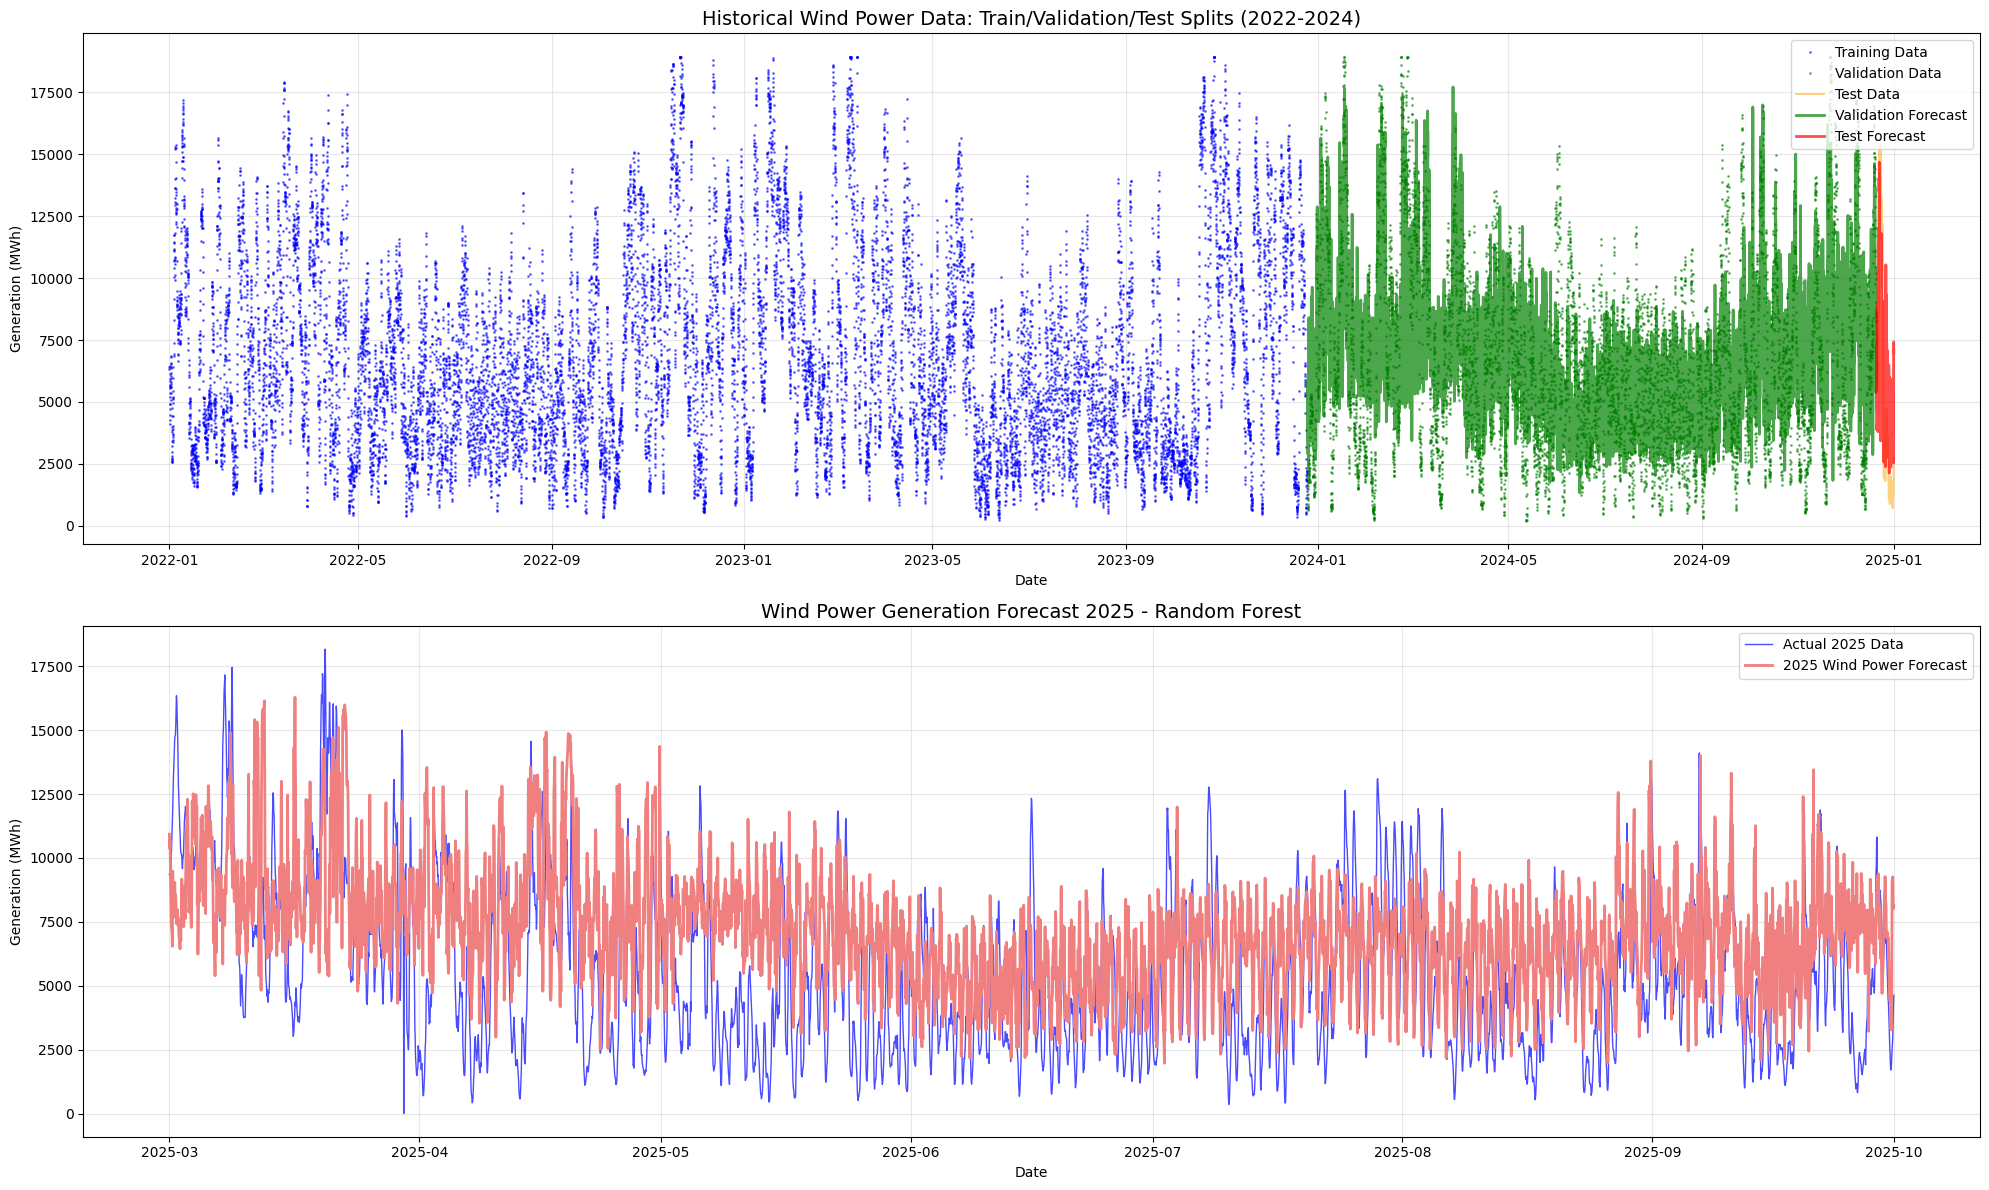

In [547]:
# Visualize train/val/test splits and model performance for wind power
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Plot 1: Historical data with splits (Mar-Sep 2022-2024)
ax1 = axes[0]
ax1.plot(train_df['ds'], train_df['y'], 'b.', label='Training Data', alpha=0.5, markersize=2)
ax1.plot(val_df['ds'], val_df['y'], 'g.', label='Validation Data', alpha=0.5, markersize=2)
ax1.plot(test_df['ds'], test_df['y'], 'orange', label='Test Data', alpha=0.5, markersize=2)

# Add predictions on validation and test sets
ax1.plot(val_forecast['ds'], val_forecast['yhat'], 'g-', label='Validation Forecast', linewidth=2, alpha=0.7)
ax1.plot(test_forecast['ds'], test_forecast['yhat'], 'r-', label='Test Forecast', linewidth=2, alpha=0.7)

ax1.set_title('Historical Wind Power Data: Train/Validation/Test Splits (2022-2024)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Generation (MWh)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: 2025 Forecast (Mar-Sep)
ax2 = axes[1]
ax2.plot(df_2025['ds'], df_2025['y'], 'blue', label='Actual 2025 Data', linewidth=1, alpha=0.7)
ax2.plot(forecast_2025['ds'], forecast_2025['yhat'], 'lightcoral', label='2025 Wind Power Forecast', linewidth=2)

ax2.set_title('Wind Power Generation Forecast 2025 - Random Forest', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Generation (MWh)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Graph 1

In [548]:
# Export 2025 forecast (Mar-Sep) to CSV
forecast_export = forecast_2025[['ds', 'yhat']].copy()
forecast_export['timestamp'] = forecast_export['ds'].dt.strftime('%Y-%m-%d %H:%M:%S')
forecast_export = forecast_export[['timestamp', 'yhat']].rename(columns={
    'timestamp': 'Timestamp',
    'yhat': 'Forecast_Generation_MWh'
})

output_file = 'wind_forecast_2025_mar_sep_hourly.csv'
forecast_export.to_csv(output_file, index=False)
print(f"2025 forecast (March to September) exported to: {output_file}")
print(f"\nSummary statistics of 2025 Mar-Sep forecast:")
print(forecast_export.describe())

2025 forecast (March to September) exported to: wind_forecast_2025_mar_sep_hourly.csv

Summary statistics of 2025 Mar-Sep forecast:
       Forecast_Generation_MWh
count              5136.000000
mean               7094.317664
std                2320.212978
min                1966.527401
25%                5593.499889
50%                7007.512086
75%                8306.389093
max               16287.851171


In [549]:
# Load actual 2025 data for comparison
df_2025 = pd.read_csv("../Gen_data/Wind_Onshore_hourly_2025.csv")
df_2025['ds'] = pd.to_datetime(df_2025['datetime'])
df_2025['y'] = df_2025['Generation (MWh)']

# 删除datetime列中2025/10/21 21:00:00之后的所有数据行
cutoff_datetime = pd.to_datetime('2025-10-21 20:00:00')
df_2025 = df_2025[df_2025['ds'] <= cutoff_datetime]

df_2025

,datetime,Area,Production Type,Generation (MWh),ds,y
0,2025/1/1 0:00,BZN|ES,Wind Onshore,2949.0,2025-01-01 00:00:00,2949.0
1,2025/1/1 1:00,BZN|ES,Wind Onshore,3222.0,2025-01-01 01:00:00,3222.0
2,2025/1/1 2:00,BZN|ES,Wind Onshore,3428.0,2025-01-01 02:00:00,3428.0
3,2025/1/1 3:00,BZN|ES,Wind Onshore,3526.0,2025-01-01 03:00:00,3526.0
4,2025/1/1 4:00,BZN|ES,Wind Onshore,3609.0,2025-01-01 04:00:00,3609.0
...,...,...,...,...,...,...
7048,2025/10/21 16:00,BZN|ES,Wind Onshore,12590.0,2025-10-21 16:00:00,12590.0
7049,2025/10/21 17:00,BZN|ES,Wind Onshore,13784.0,2025-10-21 17:00:00,13784.0
7050,2025/10/21 18:00,BZN|ES,Wind Onshore,13762.0,2025-10-21 18:00:00,13762.0
7051,2025/10/21 19:00,BZN|ES,Wind Onshore,13440.0,2025-10-21 19:00:00,13440.0


In [550]:
# Process 2025 data similar to training data
# The datetime column should already be in the correct format
df_2025['ds'] = pd.to_datetime(df_2025['datetime'])
df_2025['y'] = df_2025['Generation (MWh)']
df_2025 = df_2025[['ds', 'y']].sort_values('ds')

# Filter for March to September 2025 only
df_2025['month'] = df_2025['ds'].dt.month
df_2025 = df_2025[(df_2025['month'] >= 3) & (df_2025['month'] <= 9)].copy()
df_2025 = df_2025[['ds', 'y']]  # Keep only required columns

print(f"2025 actual data loaded (March to September):")
print(f"  Period: {df_2025['ds'].min()} to {df_2025['ds'].max()}")
print(f"  Total records: {len(df_2025)}")
print(f"  Data range: {df_2025['y'].min():.2f} to {df_2025['y'].max():.2f} MWh")

# Merge forecast with actual 2025 data (both are hourly)
comparison = pd.merge(
    forecast_2025[['ds', 'yhat']],
    df_2025[['ds', 'y']],
    on='ds',
    how='inner'
)

print(f"\nMatched records: {len(comparison)}")

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

# Calculate MAPE excluding very small values
threshold = 1000  # MWh
significant_mask = comparison['y'] >= threshold
if significant_mask.sum() > 0:
    mape = np.mean(np.abs((comparison['y'][significant_mask] - comparison['yhat'][significant_mask]) / comparison['y'][significant_mask])) * 100
else:
    mape = np.nan

print(f"\n2025 Forecast Performance Metrics:")
print("=" * 50)
print(f"MAE:  {mae:.2f} MWh")
print(f"RMSE: {rmse:.2f} MWh")
if not np.isnan(mape):
    print(f"MAPE (generation >= {threshold} MWh): {mape:.2f}%")
else:
    print(f"MAPE: N/A")

# Show data ranges
print(f"\nData ranges:")
print(f"  Actual values: {comparison['y'].min():.2f} to {comparison['y'].max():.2f} MWh")
print(f"  Forecasted values: {comparison['yhat'].min():.2f} to {comparison['yhat'].max():.2f} MWh")

2025 actual data loaded (March to September):
  Period: 2025-03-01 00:00:00 to 2025-09-30 23:00:00
  Total records: 5136
  Data range: 0.00 to 18174.00 MWh

Matched records: 5136

2025 Forecast Performance Metrics:
MAE:  2683.55 MWh
RMSE: 3295.94 MWh
MAPE (generation >= 1000 MWh): 78.32%

Data ranges:
  Actual values: 0.00 to 18174.00 MWh
  Forecasted values: 1966.53 to 16287.85 MWh


In [551]:
# Check for zero values in actual data
zero_counts = (comparison['y'] == 0).sum()
print(f"Number of zero values in actual data: {zero_counts}")

# Calculate metrics with handling for zero values
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

# Modified MAPE calculation excluding zero values
non_zero_mask = comparison['y'] != 0
mape = np.mean(np.abs((comparison['y'][non_zero_mask] - comparison['yhat'][non_zero_mask]) / comparison['y'][non_zero_mask])) * 100

print(f"\nMetrics (excluding zero values for MAPE):")
print(f"Mean Absolute Error (MAE): {mae:.2f} MW")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} MW")

# Show min/max values
print(f"\nData ranges:")
print(f"Actual values range: {comparison['y'].min():.2f} to {comparison['y'].max():.2f} MW")
print(f"Forecasted values range: {comparison['yhat'].min():.2f} to {comparison['yhat'].max():.2f} MW")

Number of zero values in actual data: 1

Metrics (excluding zero values for MAPE):
Mean Absolute Error (MAE): 2683.55 MW
Mean Absolute Percentage Error (MAPE): 88.45%
Root Mean Square Error (RMSE): 3295.94 MW

Data ranges:
Actual values range: 0.00 to 18174.00 MW
Forecasted values range: 1966.53 to 16287.85 MW


In [552]:
# Add hour of day for filtering daylight hours
comparison['hour'] = comparison['ds'].dt.hour

# Calculate installed capacity (using 95th percentile of actual values as proxy)
installed_capacity = comparison['y'].quantile(0.95)

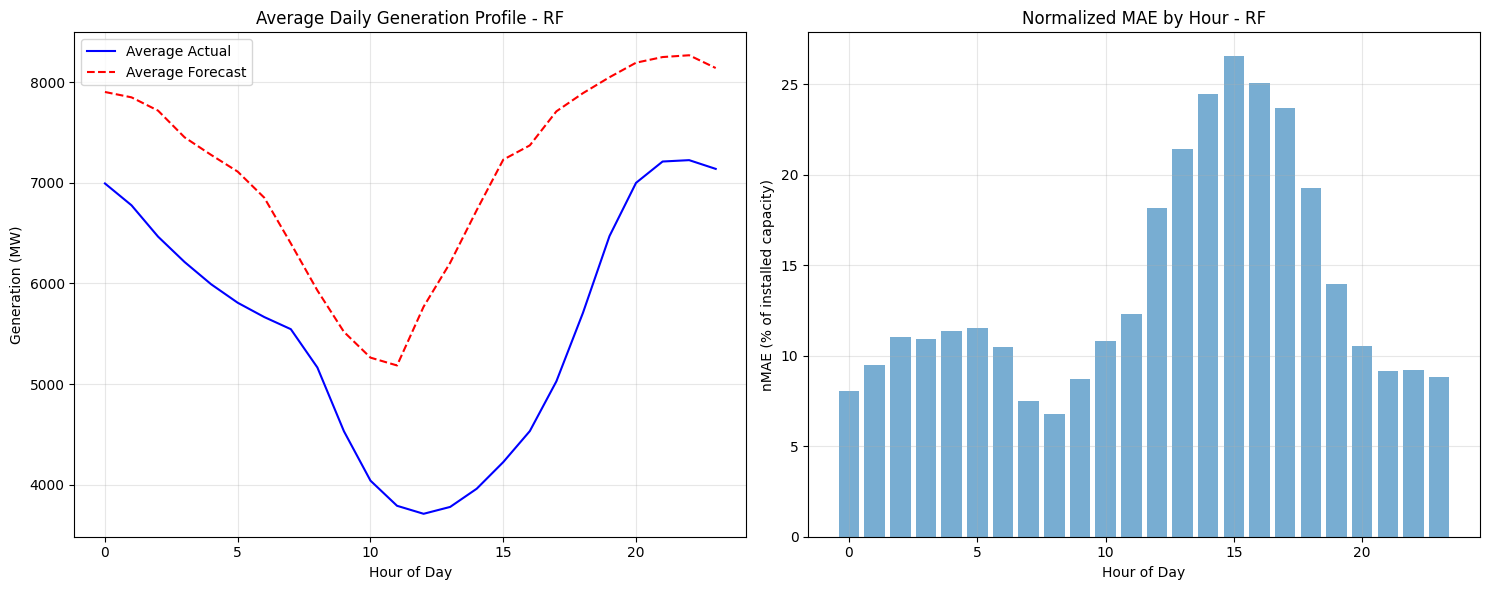

In [553]:
# Create hourly averages for error analysis
hourly_metrics = comparison.groupby('hour').agg({
    'y': 'mean',
    'yhat': 'mean'
}).reset_index()

hourly_metrics['mae'] = abs(hourly_metrics['y'] - hourly_metrics['yhat'])
hourly_metrics['nmae'] = hourly_metrics['mae'] / installed_capacity * 100

# Plot hourly performance
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(hourly_metrics['hour'], hourly_metrics['y'], 'b-', label='Average Actual')
plt.plot(hourly_metrics['hour'], hourly_metrics['yhat'], 'r--', label='Average Forecast')
plt.title('Average Daily Generation Profile - RF')
plt.xlabel('Hour of Day')
plt.ylabel('Generation (MW)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(hourly_metrics['hour'], hourly_metrics['nmae'], alpha=0.6)
plt.title('Normalized MAE by Hour - RF')
plt.xlabel('Hour of Day')
plt.ylabel('nMAE (% of installed capacity)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Graph 2

In [554]:
import numpy as np
import pandas as pd

# 假设：y_true, y_pred 是 DataFrame，含列 ["ds","y"] / ["ds","yhat"]
# 如果你只有一个 df_pred 包含真实和预测，调整下列变量
y_true = df_2025[['ds','y']].copy().sort_values('ds').reset_index(drop=True)
y_pred = forecast_2025[['ds','yhat']].copy().sort_values('ds').reset_index(drop=True)

# 1) 全局偏差
bias = (y_pred['yhat'].values - y_true['y'].values)
print("N:", len(bias))
print("Mean error (bias):", bias.mean())
print("Median error:", np.median(bias))
print("Std error:", bias.std())

# 2) 每小时平均偏差（查看是否随小时变化）
merged = pd.merge(y_true, y_pred, on='ds', how='inner')
merged['hour'] = pd.to_datetime(merged['ds']).dt.hour
hourly = merged.groupby('hour').agg(mean_y=('y','mean'),
                                    mean_yhat=('yhat','mean'),
                                    mean_err=('yhat', lambda x: (x.values - merged.loc[x.index,'y']).mean()))
print(hourly[['mean_y','mean_yhat','mean_err']])

# 3) 日循环（平均日形状比对） — 看曲线是否只偏移或放大
merged['date'] = pd.to_datetime(merged['ds']).dt.date
daily_mean_true = merged.groupby(merged['ds'].dt.hour)['y'].mean()
daily_mean_pred = merged.groupby(merged['ds'].dt.hour)['yhat'].mean()
daily_df = pd.DataFrame({'hour':range(24),'true':daily_mean_true.values,'pred':daily_mean_pred.values})
print(daily_df)

# 4) 交叉相关（检测时间滞后）
# 计算每小时序列的互相关，寻找最大相关时刻偏移
true_series = merged['y'].values - merged['y'].mean()
pred_series = merged['yhat'].values - merged['yhat'].mean()
# limited lag window e.g. +/- 6 hours
maxlag = 24
corrs = [np.corrcoef(true_series[maxlag:-maxlag], np.roll(pred_series, lag)[maxlag:-maxlag])[0,1] for lag in range(-maxlag, maxlag+1)]
lags = np.arange(-maxlag, maxlag+1)
best_lag = lags[np.nanargmax(corrs)]
print("Best lag (pred shifted by this many steps) to maximize corr:", best_lag)

N: 5136
Mean error (bias): 1553.7863165273861
Median error: 1743.1328337091445
Std error: 2906.713225955971
           mean_y    mean_yhat     mean_err
hour                                       
0     6993.710280  7902.768931   909.058651
1     6776.789720  7849.525923  1072.736204
2     6465.336449  7717.494132  1252.157684
3     6212.803738  7451.870854  1239.067116
4     5991.626168  7277.169095  1285.542927
5     5808.135514  7111.234179  1303.098665
6     5665.948598  6852.354398  1186.405800
7     5545.448598  6397.547271   852.098673
8     5164.635514  5930.331603   765.696089
9     4531.028037  5518.625554   987.597516
10    4039.869159  5262.661376  1222.792217
11    3790.196262  5184.857765  1394.661503
12    3710.696262  5768.768016  2058.071754
13    3778.985981  6205.110183  2426.124201
14    3959.892523  6728.307557  2768.415033
15    4224.621495  7230.233756  3005.612261
16    4532.630841  7372.010940  2839.380099
17    5027.042056  7710.359891  2683.317835
18    5707.2

In [555]:
# 假设 best_lag 从上一步得到 (正值表示 pred must be rolled forward)
lag = best_lag
y_pred_shifted = y_pred.copy()
y_pred_shifted['ds'] = pd.to_datetime(y_pred_shifted['ds']) + pd.to_timedelta(lag, unit='h')

# 重新合并评估
merged_shift = pd.merge(y_true, y_pred_shifted, on='ds', how='inner')
print("MAPE after shifting by", lag, "hours:",
      (np.abs(merged_shift['yhat'] - merged_shift['y']) / (merged_shift['y']+1e-9)).mean()*100)
print("MAE after shifting:", np.mean(np.abs(merged_shift['yhat'] - merged_shift['y'])))

MAPE after shifting by 2 hours: 182527318596.46503
MAE after shifting: 2618.3727053904295


In [556]:
df = train_df.copy()
df['ds_diff'] = (pd.to_datetime(df['ds']) - pd.to_datetime(df['hourly__time'])).dt.total_seconds()/3600
print(df['ds_diff'].describe())

count    17358.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: ds_diff, dtype: float64


In [557]:
df = train_df[['ds','hourly__time']].head(20)

In [558]:
df_merged = pd.merge(val_df[['ds','y']], val_df[['ds','hourly__wind_speed_100m']], on='ds')

print(df_merged['hourly__wind_speed_100m'].describe())
print(train_df['hourly__wind_speed_100m'].describe())

count    8679.000000
mean       13.911303
std         8.404856
min         0.500000
25%         7.600000
50%        12.200000
75%        18.400000
max        52.000000
Name: hourly__wind_speed_100m, dtype: float64
count    17358.000000
mean        14.838645
std          8.759549
min          0.000000
25%          8.400000
50%         13.400000
75%         19.500000
max         60.500000
Name: hourly__wind_speed_100m, dtype: float64
